# Multi-layer Perceptron

Let's look at the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST serves as a direct drop-in replacement for the original MNIST dataset (which becomes unavailable as of **11 March 2021**) for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

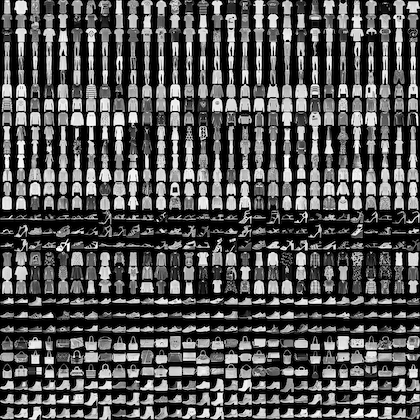

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import notebook
import time

plt.style.use('ggplot')

In [2]:
# Some hyperparameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100          # Batch gradient descent
learning_rate = 0.001

`torchvision` is a pretty handy library that is highly recommended for checking out if you are planning to work on some computer vision related projects. It wraps up many commonly used boilerplate codes, as well as the datasets, benchmark evaluations, etc.

Here for simplicity we just use the library to get the data that we need. You can do this by hand if you have some custom data, and a useful tutorial can be found [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [3]:
# Get the data
train_dataset = torchvision.datasets.FashionMNIST(root='data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Transform provides some image pre-processing functionalities.
# DataLoader: Mixes Dataset with Sampler.

100%|██████████| 26421880/26421880 [00:02<00:00, 9845690.34it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 167134.54it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3159425.85it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6623397.85it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



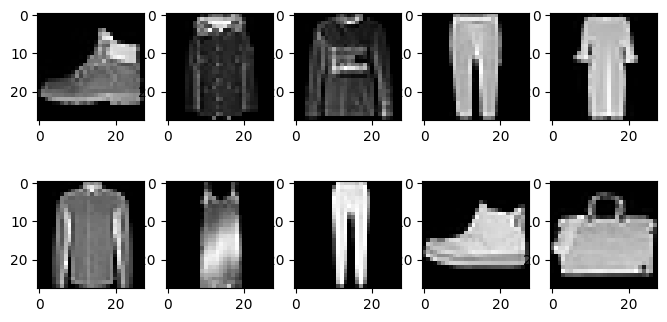

In [7]:
plt.style.use('default')

# Have a look at the data
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
for i in range(100):
  ax[i % 2, i % 5].imshow(train_dataset[i][0][0], cmap='gray', vmin=0, vmax=1)
plt.show()

In [8]:
# Define our model (2-layer MLP)
class MultilayerPerceptron(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)  # w * x + b
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.fc1(x.reshape(-1, 28 * 28))
    out = self.relu(out)
    out = self.fc2(out)
    return out

To enable GPUs for the notebook,
Navigate to Edit→Notebook Settings
select GPU from the Hardware Accelerator drop-down

In [9]:
# Let's create the model - on CPU first.

# Use GPU if supported, cpu otherwise
# device = 'cpu'
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(torch.cuda.get_device_name(0))
model = MultilayerPerceptron(input_size, hidden_size, num_classes).to(device)

In [10]:
print(model)

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # try a different optimizer!

# Train the model!
total_epochs = notebook.tqdm(range(num_epochs))

model.train()     # Set the model into `training` mode, because certain operators will perform differently during training and evaluation (e.g. dropout and batch normalization)

for epoch in total_epochs:
  for i, (images, labels) in enumerate(train_loader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (i + 1) % 10 == 0:
      total_epochs.set_description(
          'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
              epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in notebook.tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.63 %


It's actually not bad, despite that MNIST if a pretty simple benchmark.

# Convolutional Neural Network

Now let's try some (slightly) more complicated convolutional neural network.

In [16]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # We can further simplify the code if a data will be sequentially processed
    # by multiple modules: just use `nn.Sequential` to link them all.
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.fc = nn.Linear(7*7*32, num_classes)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)

    return out

In [20]:
# Some hyperparameters for Convolutional Neural Network
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# This time let's try running the program on GPU!
device = 'cuda:0'

# And let's initialize the model.
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # try a different optimizer!
# Train the model!
total_epochs = notebook.tqdm(range(num_epochs))

model.train()     # Set the model into `training` mode, because certain operators will perform differently during training and evaluation (e.g. dropout and batch normalization)

for epoch in total_epochs:
  for i, (images, labels) in enumerate(train_loader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (i + 1) % 10 == 0:
      total_epochs.set_description(
          'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
              epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # try a different optimizer!

# Train the model!
total_epochs = notebook.tqdm(range(num_epochs))

model.train()     # Set the model into `training` mode, because certain operators will perform differently during training and evaluation (e.g. dropout and batch normalization)

for epoch in total_epochs:
  for i, (images, labels) in enumerate(train_loader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (i + 1) % 10 == 0:
      total_epochs.set_description(
          'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
              epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

Now let's go back to re-use the previous training and evaluation code.

Yes, although we will work on a new model, but the training and evaluation procedure can be used without changing even a single character. This is actually a pretty nice feature because now you can put more emphasis on the model.

# Off-the-shelf Model Checkpoint

Another benefits of PyTorch is the rich pre-trained model checkpoints, which makes transfer learning much easier. Below is a list of some available models:
```
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
mnasnet = models.mnasnet1_0(pretrained=True)
```

In [21]:
import torchvision
import torchvision.models as models

# Printing the model shows all layers inside it
print(models.resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#**Task: Transfer learning (fine-tunning)**


Learn about fine-tunning in this tutorial [link text](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

Take a pre-trained model Resnet18 and finetune it on the CIFAR10 dataset available from the Pytorch library: `torchvision.datasets.CIFAR10`.

Load a ResNet18 model with the learned weights using torchvision library:
`resnet18 = models.resnet18(pretrained=True)`. This model was trained on the ImageNet dataset to classify 1000 object classes. Replace the final classification layer to perform a 10-class classification problem on the CIFAR10 dataset. You should try the two flavors of transfer learning, i.e. (1) freezing all the ResNet18 layers (feature extraction) and training the final classification layer; (2) finetuning all ResNet18 layers together with the final classification layer. Print the performance of the two models on the train and test sets.

You may find this tutorials useful:
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

2. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html